# Data Analysis

Analysis of bacterial data (wild type and mutants cells) with EfficientNet features and cell areas.

**Pipeline Overview:**
- **Step 1**: Pre-processing (merge data, add labels, filter low area, remove constant columns, outlier detection).
- **Step 2**: Subset selection.
- **Step 3**: Data scaling (standardize WT, save scaler).
- **Step 4**: PHATE
- **Step 5**: Angle aperture plot

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import phate
import scanpy as sc
import scvelo as scv
from scipy.optimize import least_squares
from matplotlib.patches import Circle, Arc
from matplotlib.patches import Ellipse, Arc
import hdbscan

# Set plot style
sns.set_style('whitegrid')

# Create directories
os.makedirs('/scratch/leuven/359/vsc35907/big_data_feature_extraction/analysis/results/', exist_ok=True)

/data/leuven/359/vsc35907/miniconda3/envs/omnipose/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Pre-processing

In [ ]:
import os
import pandas as pd
import numpy as np
import shutil

# Define paths
feature_file = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/features_model_lr_3e3_adamw_wd_1e5.csv'
area_file = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/area_cells.csv'
output_dir = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/clean_data'
garbage_dir = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/analysis/garbage_cells'

# Create directories
os.makedirs(garbage_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Define chunk size
chunk_size = 20000

# Helper functions
def normalize_path(path):
    """Normalize file paths to ensure consistency."""
    dirs = path.split("/")
    if len(dirs) == 3:
        path = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/' + path
    return path

def extract_batch(path):
    return int(os.path.basename(path).split()[0][:-3])

def extract_group(path):
    basename = os.path.basename(path)
    directory = os.path.dirname(path)
    pieces = basename.split()
    if len(pieces) == 5:
        group = pieces[3]
    else:
        group = pieces[2]
    return int(group)

def process_and_save(df, key, gene_mapping, output_dir):   
    
    # Add gene info
    df['gene'] = np.where(
        df['label'] == 1,
        df['group'].map(gene_mapping),
        np.nan
    )

    # Save to file
    if not df.empty:
        output_file = os.path.join(output_dir, f"clean_{key[0]}_{key[1]}_{key[2]}.csv")
        df.to_csv(
            output_file,
            mode='a',  # append if file exists
            header=not os.path.exists(output_file),  # write header only if file does not exist
            index=False
        )
        print(f"Saved combination {key} to {output_file}, Shape: {df.shape}")
    else:
        print(f"Combination {key} has no rows after preprocessing, skipping save")

In [ ]:
# Load gene mapping
gene_df = pd.read_csv('/data/leuven/359/vsc35907/EfficientNet_feature_extraction/mutant_names.csv')
gene_mapping = gene_df.set_index('group')['gene'].to_dict()

# Build area dictionary with normalized paths
area_dict = {}
for area_chunk in pd.read_csv(area_file, chunksize=chunk_size):
    for _, row in area_chunk.iterrows():
        area_dict[normalize_path(row['image_path'])] = row['area']
print(f"Built area_dict with {len(area_dict)} entries")

# Initialize accumulators
combo_dfs = {}
prev_combos = set()

# Process feature file in chunks
for i, feature_chunk in enumerate(pd.read_csv(feature_file, chunksize=chunk_size)):
    
    print(f"\nProcessing chunk {i+1}...")
    
    # if i < 20:
    #     continue
    
    # Normalize image_path in feature_chunk
    feature_chunk['image_path'] = feature_chunk['image_path'].apply(normalize_path)

    # Merge with area data
    feature_chunk['area'] = feature_chunk['image_path'].map(area_dict)

    # Debug: Check for unmatched image_path
    unmatched = feature_chunk[feature_chunk['area'].isna()]['image_path']
    if not unmatched.empty:
        print(f"Warning: {len(unmatched)} unmatched image_path in chunk {i+1}. Sample: {unmatched.iloc[:5].tolist()}")

    
    print(f"Removing rows with any NaN, shape: {feature_chunk.shape}")
    feature_chunk = feature_chunk.dropna()
    print(f"After removing rows with any NaN, shape: {feature_chunk.shape}")

    # Warn if all rows were removed
    if feature_chunk.empty:
        print(f"Warning: All rows removed in chunk {i+1}. Check data consistency.")
        continue

    # Add metadata
    feature_chunk['label'] = feature_chunk['image_path'].apply(lambda x: 1 if 'mutant' in x.lower() else 0)
    feature_chunk['batch'] = feature_chunk['image_path'].apply(extract_batch)
    feature_chunk['group'] = feature_chunk['image_path'].apply(extract_group)

    # Move image_path to end
    image_path = feature_chunk.pop('image_path')
    feature_chunk['image_path'] = image_path

    # Remove garbage cells
    garbage_df = feature_chunk[feature_chunk['area'] <= 270]
    for img in garbage_df['image_path']:
        shutil.copy2(img, os.path.join(garbage_dir, os.path.basename(img)))
    feature_chunk = feature_chunk[feature_chunk['area'] > 270]
    print(f"Removed {len(garbage_df)} low-area cells in chunk {i+1}")
    print(f"Shape: {feature_chunk.shape}")

    # Group by combination
    grouped = feature_chunk.groupby(['label', 'batch', 'group'])
    current_combos = set(grouped.groups.keys())

    # Accumulate data
    for key, group_df in grouped:
        if key in combo_dfs:
            combo_dfs[key] = pd.concat([combo_dfs[key], group_df])
        else:
            combo_dfs[key] = group_df.copy()

    # Process completed combinations
    completed_combos = prev_combos - current_combos
    for key in completed_combos:
        process_and_save(combo_dfs[key], key, gene_mapping, output_dir)
        del combo_dfs[key]
    prev_combos = current_combos
    print(f"Chunk {i+1} processed, active combinations: {len(combo_dfs)}")

# Process remaining combinations
for key in list(combo_dfs.keys()):
    process_and_save(combo_dfs[key], key, gene_mapping, output_dir)
    del combo_dfs[key]

print("Preprocessing complete. Cleaned files saved in", output_dir)

In [ ]:
# DELETES ALL THE CSV FILES IN THE OUTPUT DIRECTORY!!!!!!!!!!
# DO NOT RUN THIS CELL!!! I REPET: DO NOT RUN THIS CELL!!!!!!

# import os

# for filename in os.listdir(output_dir):
#     file_path = os.path.join(output_dir, filename)
#     if os.path.isfile(file_path):
#         os.remove(file_path)
# print(os.listdir(output_dir))

##### Check csv files shape

In [ ]:
files = os.listdir(output_dir)
files = [f for f in files if '.csv' in f]
print(f'total csv files found: {len(files)}')
for filename in files:
    file_path = os.path.join(output_dir, filename)
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        print(f'file: {os.path.basename(file_path)} shape: {df.shape}')  # Remove the parentheses
#print(os.listdir(output_dir))

## Steps 2-7: Subset Selection, Normalization, Outliers Filtering, PHATE, and Aperture Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.interpolate import make_interp_spline
from matplotlib.patches import Arc as MplArc

def fit_spline(points, k=3, s=None):
    """Fit a smooth B-spline to 2D points."""
    x, y = points[:, 0], points[:, 1]
    
    # Sort points by x to ensure smooth spline
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    # Remove duplicates to avoid spline fitting issues
    unique_points = np.unique(np.vstack((x_sorted, y_sorted)), axis=1, return_index=True)
    x_unique = x_sorted[unique_points[1]]
    y_unique = y_sorted[unique_points[1]]
    
    if len(x_unique) < k + 1:
        raise ValueError(f"Not enough unique points ({len(x_unique)}) for spline of degree {k}")
    
    # Create B-spline
    spline = make_interp_spline(x_unique, y_unique, k=k, check_finite=True)
    
    # Compute approximate curvature (average second derivative)
    x_range = np.linspace(min(x_unique), max(x_unique), 100)
    second_deriv = spline.derivative(nu=2)(x_range)
    avg_curvature = np.mean(np.abs(second_deriv))
    
    return spline, avg_curvature

def compute_arc_length(points):
    """Compute the arc length of the 2D curve defined by the given points."""
    diffs = np.diff(points, axis=0)
    distances = np.linalg.norm(diffs, axis=1)
    return np.sum(distances)

def compute_width(points):
    """Compute the width (x-span) of the points."""
    return np.max(points[:, 0]) - np.min(points[:, 0])

def compute_height(points):
    """Compute the height (y-span) of the points."""
    return np.max(points[:, 1]) - np.min(points[:, 1])

def compute_center(points):
    """Compute the geometric center of the points."""
    return np.mean(points[:, 0]), np.mean(points[:, 1])

def visualize_horseshoe(points, areas, cell_stages, spline, curvature, batch, group, label_str, save_dir):
    """Visualize PHATE points colored by area and cell stage, with fitted spline."""
    fig, ax = plt.subplots(figsize=(8, 8))

    sc_area = ax.scatter(points[:, 0], points[:, 1], c=areas, s=50, alpha=0.3, cmap='viridis', label='Area')
    plt.colorbar(sc_area, label='Area', shrink=0.7)

    cell_stages = np.array(cell_stages)
    non_nan_mask = ~pd.isna(cell_stages)
    if non_nan_mask.sum() > 0:
        stage_dict = {
            'B': '#03ecfc',
            'C': '#7bfc03',
            'D': '#fc03d3'
        }
        unique_stages = np.unique(cell_stages[non_nan_mask])
        for stage in unique_stages:
            if stage in stage_dict:
                stage_mask = (cell_stages == stage) & non_nan_mask
                ax.scatter(
                    points[stage_mask, 0], points[stage_mask, 1],
                    c=[stage_dict[stage]], s=50, label=f'Cell Stage {stage}', alpha=0.8
                )

    # Plot spline
    x_range = np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), 100)
    y_spline = spline(x_range)
    ax.plot(x_range, y_spline, color='red', linestyle='--', linewidth=2, label='Fitted spline')

    # Plot geometric center
    center_x, center_y = compute_center(points)
    ax.scatter([center_x], [center_y], c='green', s=100, marker='x', label='Centroid')

    data_min = np.min(points)
    data_max = np.max(points)
    padding = (data_max - data_min) * 0.1
    axis_limit_min = data_min - padding
    axis_limit_max = data_max + padding
    ax.set_xlim(axis_limit_min, axis_limit_max)
    ax.set_ylim(axis_limit_min, axis_limit_max)

    ax.set_aspect('equal')
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)
    ax.grid(True, alpha=0.3)
    plt.title(f'Horseshoe Plot: Label {label_str}, Batch {batch}, Group {group}\nAverage Curvature = {curvature:.4f}')

    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, f'horseshoe_label_{label_str}_batch_{batch}_group_{group}.png')
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    plt.close()

def analyze_horseshoe(points, areas, cell_stages, batch, group, label_str, save_dir):
    """Analyze a horseshoe-shaped data cloud and save visualization."""
    if not isinstance(points, np.ndarray) or points.shape[1] != 2:
        raise ValueError("Input must be a NumPy array with shape (n, 2)")

    try:
        spline, curvature = fit_spline(points)
    except ValueError as e:
        print(f"Error fitting spline for Label {label_str}, Batch {batch}, Group {group}: {e}")
        return None

    arc_length = compute_arc_length(points)
    width = compute_width(points)
    height = compute_height(points)
    center_x, center_y = compute_center(points)

    visualize_horseshoe(points, areas, cell_stages, spline, curvature, batch, group, label_str, save_dir)

    return {
        'centroid': (center_x, center_y),
        'spline_function': 'B-spline degree 3',  # Descriptive string, as spline object isn't JSON-serializable
        'curvature': curvature,
        'arc_length': arc_length,
        'width': width,
        'height': height,
        'geometric_center': (center_x, center_y)
    }

In [3]:
def process_subset(df, feature_columns, label_str, batch, group, results_dir, outliers_excluded=True):
    """Process a subset of the DataFrame for a given label, batch, and group."""
    try:
        print(f"\nProcessing Label {label_str}, Batch {batch}, Group {group}...")
        if df.shape[0] < 100:
            print(f'Skipping Label {label_str}, Batch {batch}, Group {group}: Insufficient data (n={df.shape[0]})')
            return None
        
        print(f'Initial shape: {df.shape}')
        
        # Step 1: Initial Outlier Removal
        features = df[feature_columns].values
        inlier_mask_initial = np.all(
            np.abs((features - np.mean(features, axis=0)) / np.std(features, axis=0)) <= 12,
            axis=1
        )
        inlier_indices = df.index[inlier_mask_initial]
        features = features[inlier_mask_initial]
        print(f'Shape after outlier removal: {features.shape}')

        # Step 2: Normalization
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
        
        # Step 3: PHATE
        phate_op = phate.PHATE(n_components=2, random_state=42, n_jobs=-1, verbose=False)
        phate_data = phate_op.fit_transform(features)
        print(f'PHATE shape: {phate_data.shape}')
        unique_points = np.unique(phate_data, axis=0).shape[0]
        print(f'Number of unique PHATE points: {unique_points}')

        # Step 4: Select additional data using final indices
        areas = df.loc[inlier_indices, 'area'].values
        cell_stages = df.loc[inlier_indices, 'cell_stage'].values
        print(f'Areas shape: {areas.shape}')
        print(f'Cell stages shape: {cell_stages.shape}')

        # Step 5: Shape analysis (curvature + visualization)
        result = analyze_horseshoe(phate_data, areas, cell_stages, batch, group, label_str, results_dir)
        print(result)

        result.update({'batch': batch, 'group': group, 'label': label_str})
        print(f'Centroid: {result["centroid"]}')
        print(f'Curvature (a): {result["curvature"]:.4f}')
        print(f'Arc length: {result["arc_length"]:.2f}')
        print(f'Width: {result["width"]:.2f}')
        print(f'Height: {result["height"]:.2f}')

        return result

    except Exception as e:
        print(f'Error processing Label {label_str}, Batch {batch}, Group {group}: {e}')
        return None

#### Run analysis on each individual group

In [4]:
import os
import pandas as pd
import numpy as np

# Results directory
results_dir = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/results/phate_plots3'
csv_dir = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/clean_data'
os.makedirs(results_dir, exist_ok=True)

# Checkpoint file
checkpoint_file = os.path.join(results_dir, 'checkpoint.txt')

# Load processed files from checkpoint
processed_files = set()
try:
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'r') as f:
            processed_files = set(line.strip() for line in f if line.strip())
        print(f"Loaded {len(processed_files)} processed files from checkpoint")
except Exception as e:
    print(f"Error reading checkpoint file: {e}")

feature_columns = [f'feature_{i}' for i in range(1280)]

# Store results
results = []

# Process each label
for file in os.listdir(csv_dir):  # Limited to first two files; remove [:2] for all files
    if file in processed_files:
        print(f"Skipping already processed file: {file}")
        continue
    
    try:
        _, label_str, batch, group = file.split("_")
        group = group[:-4]
    except ValueError:
        print(f"Skipping file with invalid name format: {file}")
        continue
    
    try:
        df = pd.read_csv(os.path.join(csv_dir, file))
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue
    
    # Add cell_stage column initialized to NaN
    df['cell_stage'] = np.nan
    
    # Process the subset
    result = process_subset(df, feature_columns, label_str, batch, group, results_dir)
    if result is not None:
        results.append(result)
        # Update checkpoint
        try:
            with open(checkpoint_file, 'a') as f:
                f.write(f"{file}\n")
            processed_files.add(file)
            print(f"Added {file} to checkpoint")
        except Exception as e:
            print(f"Error updating checkpoint for {file}: {e}")

# Save results to CSV
if results:
    results_df = pd.DataFrame(results)
    try:
        results_df.to_csv(os.path.join(results_dir, 'aperture_results.csv'), index=False)
        print('\nAnalysis complete. Results saved to aperture_results.csv')
    except Exception as e:
        print(f"Error saving results CSV: {e}")
else:
    print('\nNo new results to save.')

Loaded 269 processed files from checkpoint
Skipping already processed file: clean_0_190605_6.csv
Skipping already processed file: clean_0_181213_4.csv
Skipping already processed file: clean_0_190531_5.csv
Skipping already processed file: clean_1_190425_98.csv
Skipping already processed file: clean_0_190423_1.csv
Skipping already processed file: clean_0_190426_6.csv
Skipping already processed file: clean_1_190425_99.csv
Skipping already processed file: clean_0_190604_2.csv
Skipping already processed file: clean_1_190425_67.csv
Skipping already processed file: clean_0_190423_5.csv
Skipping already processed file: clean_1_190425_84.csv
Skipping already processed file: clean_0_190605_8.csv
Skipping already processed file: clean_0_190601_2.csv
Skipping already processed file: clean_0_190501_9.csv
Skipping already processed file: clean_1_190424_43.csv
Skipping already processed file: clean_1_190425_76.csv
Skipping already processed file: clean_0_190525_2.csv
Skipping already processed file: 

### Download The Images

```
scp 'vsc35907@login.hpc.kuleuven.be:/scratch/leuven/359/vsc35907/big_data_feature_extraction/results/phate_plots/outliers_included/*' /Users/theo/Desktop/phate_plots
```

#### Plot Cell Cycle Trajectories Fitted Parabolas

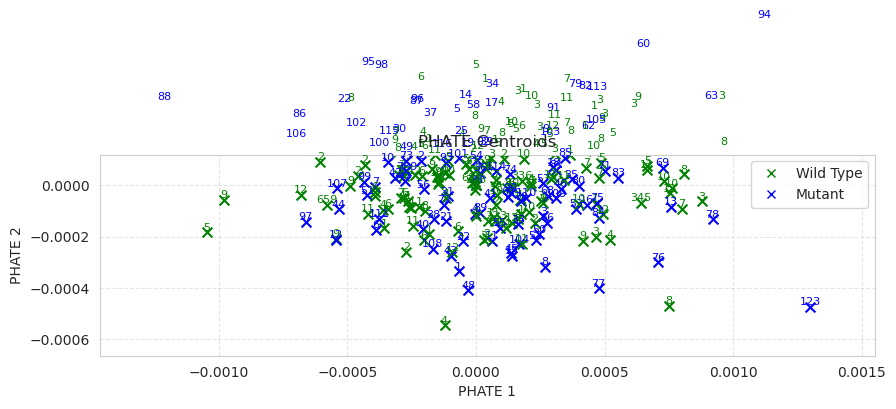

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Load the data
try:
    df = pd.read_csv(os.path.join(results_dir, 'aperture_results.csv'), sep=',')
except Exception as e:
    print(f"Error reading CSV: {e}")
    exit(1)

# Parse columns
try:
    df['centroid'] = df['centroid'].apply(ast.literal_eval)
except Exception as e:
    print(f"Error parsing columns: {e}")
    exit(1)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))
colors = {'0': 'green', '1': 'blue'}  # Wild Type and Mutant

# Track min/max for axis limits
x_all, y_all = [], []

# Plot centroids
for idx, row in df.iterrows():
    try:
        label = row['label']
        color = colors.get(str(label), 'gray')
        
        # Extract centroid
        x_centroid, y_centroid = row['centroid']
        
        # Plot centroid
        ax.scatter(x_centroid, y_centroid, color=color, marker='x', s=50)
        
        # Annotate with group
        ax.text(x_centroid, y_centroid, str(row['group']), color=color, ha='center', va='bottom', fontsize=8)
        
        # Collect coordinates for axis limits
        x_all.append(x_centroid)
        y_all.append(y_centroid)
    except Exception as e:
        print(f"Error processing row {idx}: {e}")
        continue

# Axes and layout
ax.set_xlabel('PHATE 1')
ax.set_ylabel('PHATE 2')
ax.set_title('PHATE Centroids')
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.5)

# Set axis limits with padding
padding = 0.1
x_min, x_max = min(x_all), max(x_all)
y_min, y_max = min(y_all), max(y_all)
x_pad = (x_max - x_min) * padding
y_pad = (y_max - y_min) * padding
ax.set_xlim(x_min - x_pad, x_max + x_pad)
ax.set_ylim(y_min - y_pad, y_pad)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', marker='x', linestyle='None', label='Wild Type'),
    Line2D([0], [0], color='blue', marker='x', linestyle='None', label='Mutant')
]
ax.legend(handles=legend_elements)

# Save and show plot
try:
    plt.savefig(os.path.join(results_dir, 'phate_centroids.png'), 
                bbox_inches='tight', dpi=300)
except Exception as e:
    print(f"Error saving plot: {e}")
plt.show()
plt.close()

#### Pair Plot Fitted Elipses data variables 

In [6]:
# Read the CSV file
df = pd.read_csv(os.path.join(results_dir, 'aperture_results.csv'), sep=',')

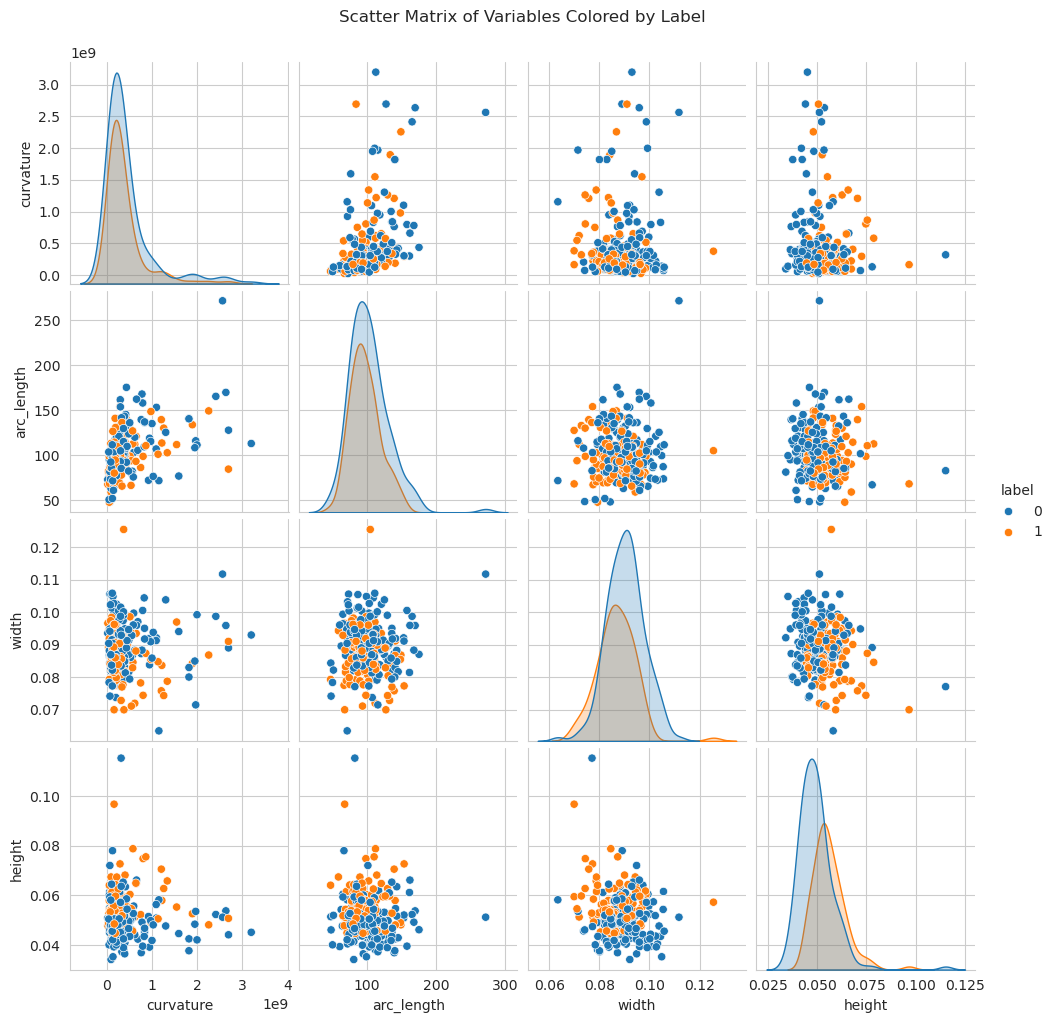

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Drop only 'batch' and 'group', keep 'label' for coloring
df = df.drop(columns=['batch', 'group'])

# Create a scatter matrix with points colored by 'label'
sns.pairplot(df, hue='label')
plt.suptitle('Scatter Matrix of Variables Colored by Label', y=1.02)
plt.savefig(os.path.join(results_dir, 'pair_plot.png'))
plt.show()
